## Imports

In [283]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import roc_curve, auc

## Parameters

### Inputs

In [284]:
edges_inputs_df = pd.read_csv("../inputs/edges_input.csv")
edges_inputs_label = edges_inputs_df['label'].values

In [285]:
radnet_inputs_df = pd.read_csv("../inputs/radnet_input.csv")
radnet_inputs_label = radnet_inputs_df['label'].values

### Outputs

In [286]:
fuzzy_output_df = pd.read_csv("../outputs/fuzzy_output.csv")
fuzzy_output_class = fuzzy_output_df['class'].values
fuzzy_output_confidence = fuzzy_output_df['confidence'].values

In [287]:
kalman_output_df = pd.read_csv("../outputs/kalman_output.csv")
kalman_output_class = kalman_output_df['class'].values
kalman_output_confidence = kalman_output_df['confidence'].values

## Confiança

### Confiança x Arestas

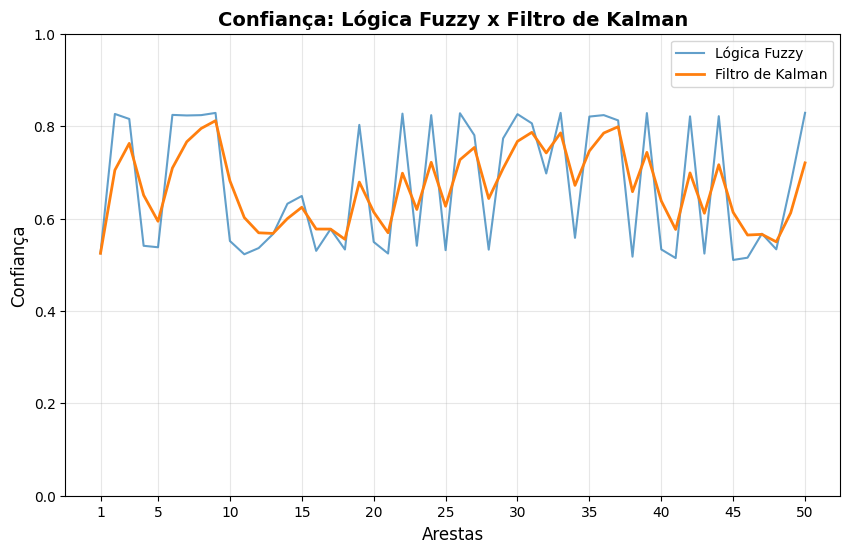

In [288]:
plt.figure(figsize=(10,6))

x_values = np.arange(1, len(fuzzy_output_confidence) + 1)

plt.plot(x_values, fuzzy_output_confidence, label="Lógica Fuzzy", alpha=0.7)
plt.plot(x_values, kalman_output_confidence, label="Filtro de Kalman", linewidth=2)

plt.title("Confiança: Lógica Fuzzy x Filtro de Kalman", fontsize=14, fontweight='bold')
plt.xlabel("Arestas", fontsize=12)
plt.ylabel("Confiança", fontsize=12)

plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

n = len(fuzzy_output_confidence)
ticks = [1] + list(range(5, n + 1, 5))
plt.xticks(ticks)

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/fuzzy_logic_kalman_filter.png', bbox_inches='tight')
plt.show()

### Mudança na Confiança (Fuzzy)

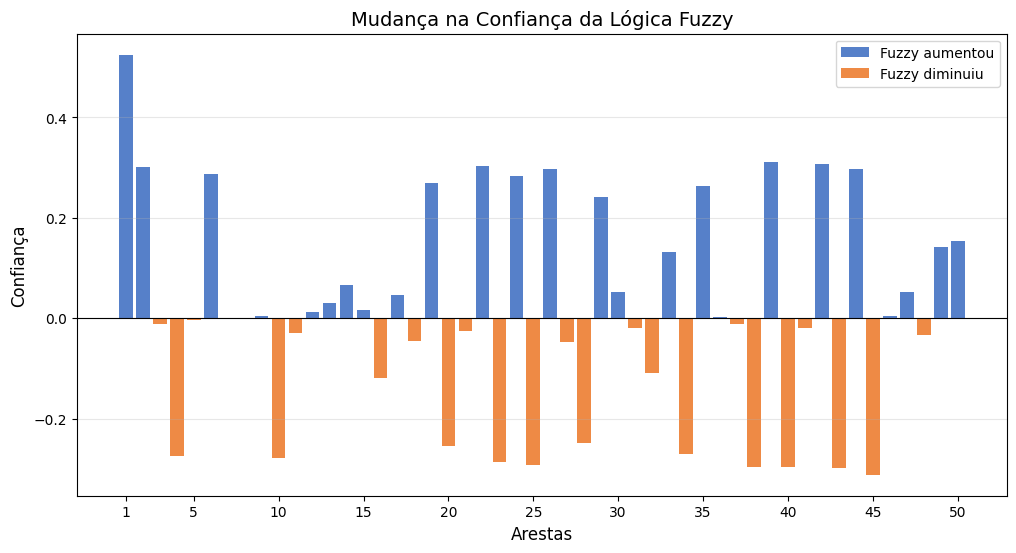

In [289]:
fuzzy_mudanca = np.diff(fuzzy_output_confidence, prepend=0)

plt.figure(figsize=(12, 6))

x_values = np.arange(1, len(fuzzy_mudanca) + 1)

fuzzy_pos = np.where(fuzzy_mudanca >= 0, fuzzy_mudanca, 0)
fuzzy_neg = np.where(fuzzy_mudanca < 0, fuzzy_mudanca, 0)

plt.bar(x_values, fuzzy_pos, color='#4472C4', label='Fuzzy aumentou', alpha=0.9)
plt.bar(x_values, fuzzy_neg, color='#ED7D31', label='Fuzzy diminuiu', alpha=0.9)

plt.title("Mudança na Confiança da Lógica Fuzzy", fontsize=14)
plt.xlabel("Arestas", fontsize=12)
plt.ylabel("Confiança", fontsize=12)

plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0, color='black', linewidth=0.8)

n = len(fuzzy_mudanca)
ticks = [1] + list(range(5, n + 1, 5))
plt.xticks(ticks)

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/fuzzy_confidence_change.png', bbox_inches='tight')
plt.show()

### Mudança na Confiança (Kalman)

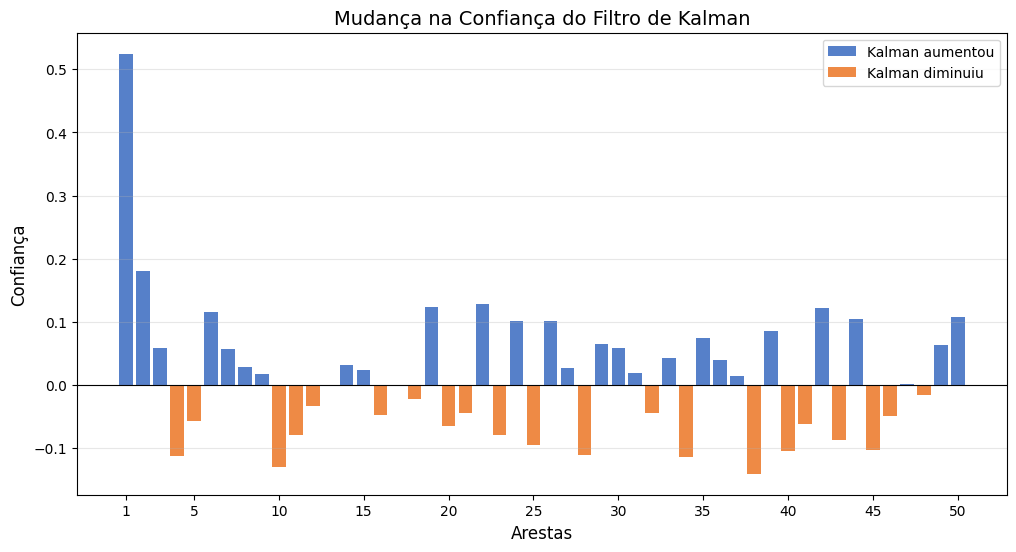

In [290]:
kalman_mudanca = np.diff(kalman_output_confidence, prepend=0)

plt.figure(figsize=(12, 6))

x_values = np.arange(1, len(kalman_mudanca) + 1)

kalman_pos = np.where(kalman_mudanca >= 0, kalman_mudanca, 0)
kalman_neg = np.where(kalman_mudanca < 0, kalman_mudanca, 0)

plt.bar(x_values, kalman_pos, color='#4472C4', label='Kalman aumentou', alpha=0.9)
plt.bar(x_values, kalman_neg, color='#ED7D31', label='Kalman diminuiu', alpha=0.9)

plt.title("Mudança na Confiança do Filtro de Kalman", fontsize=14)
plt.xlabel("Arestas", fontsize=12)
plt.ylabel("Confiança", fontsize=12)

plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0, color='black', linewidth=0.8)

n = len(kalman_mudanca)
ticks = [1] + list(range(5, n + 1, 5))
plt.xticks(ticks)

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/kalman_confidence_change.png', bbox_inches='tight')
plt.show()

### Performance

In [291]:
def ground_truth(edges_label, radnet_label):
    gt = []
    for e, r in zip(edges_label, radnet_label):
        if e == 1 and r == 1:
            gt.append(1.0)
        elif e == 0 and r == 0:
            gt.append(0.0)
        else:
            gt.append(0.5)
    return np.array(gt)

gt = ground_truth(edges_inputs_label, radnet_inputs_label)

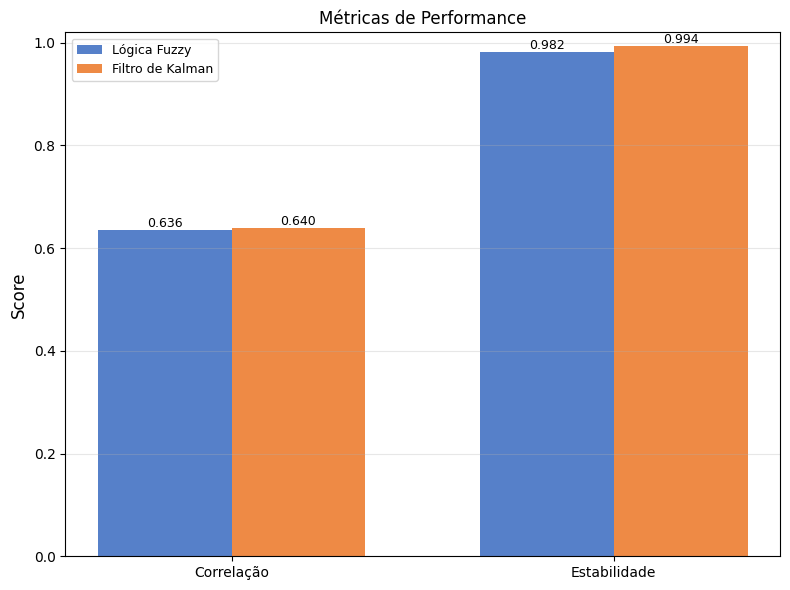

In [292]:
corr_f, _ = spearmanr(fuzzy_output_confidence, gt)
corr_k, _ = spearmanr(kalman_output_confidence, gt)
mse_f = np.mean((fuzzy_output_confidence - gt) ** 2)
mse_k = np.mean((kalman_output_confidence - gt) ** 2)
var_f = np.var(fuzzy_output_confidence)
var_k = np.var(kalman_output_confidence)

fig, ax2 = plt.subplots(figsize=(8, 6))
metricas = ['Correlação', 'Estabilidade']
fuzzy_vals = [corr_f, 1-var_f]
kalman_vals = [corr_k, 1-var_k]

x_pos = np.arange(len(metricas))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, fuzzy_vals, width, label='Lógica Fuzzy', alpha=0.9, color='#4472C4')
bars2 = ax2.bar(x_pos + width/2, kalman_vals, width, label='Filtro de Kalman', alpha=0.9, color='#ED7D31')

ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Métricas de Performance', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(metricas, fontsize=10)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0, 1.02])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/validation_fuzzy_kalman.png', bbox_inches='tight')
plt.show()

### ROC

In [293]:
y_edges = edges_inputs_df['label'].values.astype(int)
y_rad   = radnet_inputs_df['label'].values.astype(int)
p_fuzzy  = fuzzy_output_df['confidence'].values.astype(float)
p_kalman = kalman_output_df['confidence'].values.astype(float)

mask_gold = (y_edges == y_rad)
y_gold = y_edges[mask_gold]

y_soft = np.where(mask_gold, y_edges, 0.5)
y_all = (y_soft >= 0.5).astype(int)

def brier(p, y): 
    return np.mean((p - y)**2)

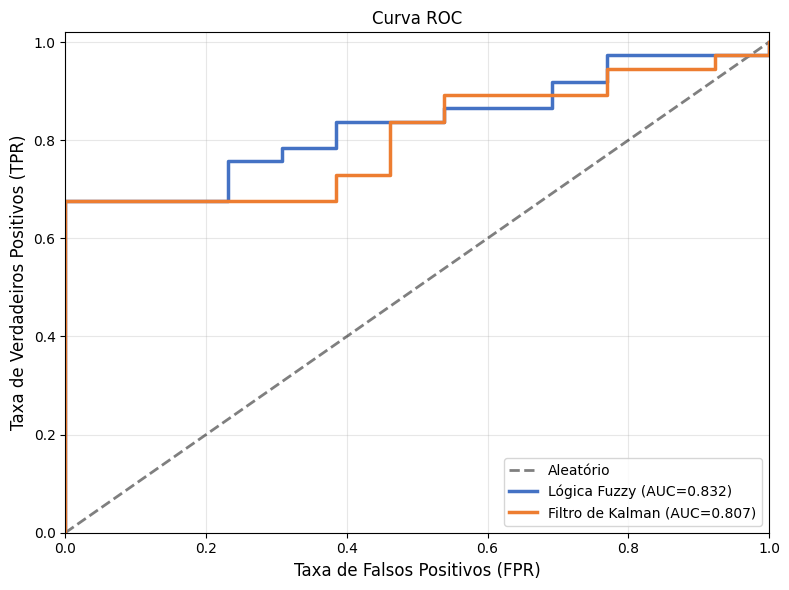

In [294]:
fpr_f_all, tpr_f_all, _ = roc_curve(y_all, p_fuzzy)
fpr_k_all, tpr_k_all, _ = roc_curve(y_all, p_kalman)
auc_f_all = auc(fpr_f_all, tpr_f_all)
auc_k_all = auc(fpr_k_all, tpr_k_all)

plt.figure(figsize=(8, 6))
plt.plot([0,1], [0,1], 'k--', linewidth=2, alpha=0.5, label='Aleatório')
plt.plot(fpr_f_all, tpr_f_all, linewidth=2.5, label=f'Lógica Fuzzy (AUC={auc_f_all:.3f})', color='#4472C4')
plt.plot(fpr_k_all, tpr_k_all, linewidth=2.5, label=f'Filtro de Kalman (AUC={auc_k_all:.3f})', color='#ED7D31')
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
plt.title('Curva ROC', fontsize=12)
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1.02])
plt.tight_layout()

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/curve_roc_full.png', bbox_inches='tight')
plt.show()

### Calibração

In [295]:
y_edges = edges_inputs_df['label'].values.astype(int)
y_rad   = radnet_inputs_df['label'].values.astype(int)
p_fuzzy  = fuzzy_output_df['confidence'].values.astype(float)
p_kalman = kalman_output_df['confidence'].values.astype(float)

mask_gold = (y_edges == y_rad)
y_gold = y_edges[mask_gold]

y_soft = np.where(mask_gold, y_edges, 0.5)
y_all = (y_soft >= 0.5).astype(int)

def brier(p, y): 
    return np.mean((p - y)**2)

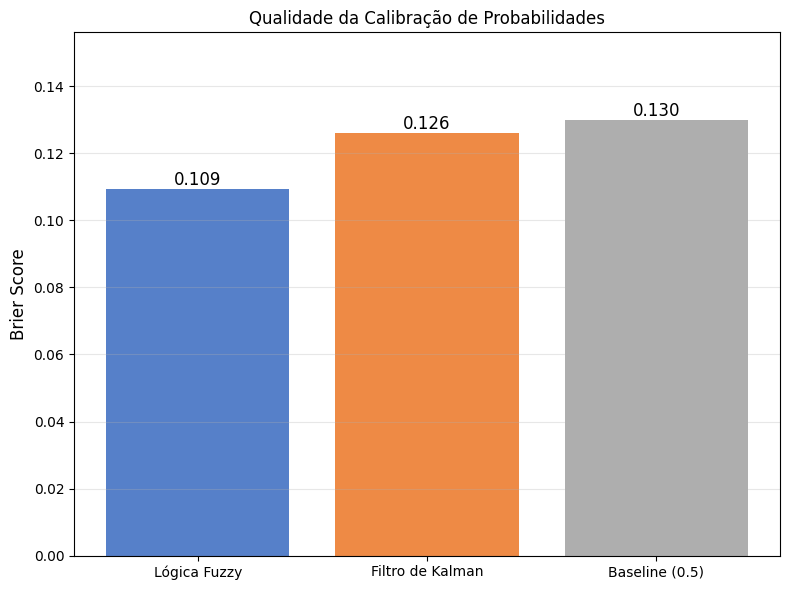

In [296]:
brier_f = brier(p_fuzzy, y_soft)
brier_k = brier(p_kalman, y_soft)
brier_base = brier(np.full_like(p_fuzzy, 0.5), y_soft)

plt.figure(figsize=(8, 6))
barras = plt.bar(['Lógica Fuzzy', 'Filtro de Kalman', 'Baseline (0.5)'], 
                 [brier_f, brier_k, brier_base],
                 color=['#4472C4', '#ED7D31', '#A5A5A5'],
                 alpha=0.9)

plt.ylabel('Brier Score', fontsize=12)
plt.title('Qualidade da Calibração de Probabilidades', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([0, max(brier_f, brier_k, brier_base) * 1.2])

for bar in barras:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/brier_score.png', bbox_inches='tight')
plt.show()